In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.include import *
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 16, 16)
# latt_size = (16, 16, 16, 32)
# latt_size = (16, 16, 16, 16)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
latt_size = (8, 8, 8, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
# latt_size = (2, 2, 2, 2)
# mass = -3.5
# mass = -0.8
# mass = -0.5
# mass = 0.05
# mass = 0.0
mass = -0.05
# kappa = 0.4
# kappa = 0.125
# kappa = 0.5
kappa = 1 / (2 * mass + 8)
dtype = torch.complex128
# dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_mg(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
verbose = True


    @@@@@@######QCU NOTES START######@@@@@@@
    Guide:
    0. Required: MPI(e.g. 4.1.2), CUDA(e.g. 12.4), CMAKE(e.g. 3.22.1), GCC(e.g. 11.4.0), HDF5-MPI(e.g. 1.10.7,'apt install libhdf5-mpi-dev && export HDF5_MPI="ON" && pip install --no-binary=h5py h5py').
    1. The libqcu.so was compiled when pyqcu setup in download_path/PyQCU/lib, please add this path to your LD_LIBRARY_PATH.
    2. The QCU(PyQCU) splite grid by x->y->z->t, lattice by x->y->z->t->p->d[x,y,z,t]->c->c or x->y->z->t->c->s(->p) and x->y->z->t->c->s->c->s(->p).
    3. The QUDA(PyQUDA) splite grid by t->z->y->x, lattice by c->c->x->y->z->t->p->d[x,y,z,t] or c->s->x->y->z->t(->p) and c->s->c->s->x->y->z->t(->p).
    4. The QCU input params in numpy array(dtype=np.int32), argv in  numpy array(dtype=np.float32 or float64) array, set_ptrs in numpy array(dtype=np.int64), other in cupy array(dtype=cp.complex64 or complex128).
    5. The smallest lattice size is (wilson:x=4,y=4,z=4,t=4;clover:x=8,y=8,z=8,t=8) that QCU support

In [2]:
hopping_plus_list = []
hopping_minus_list = []
for ward in range(4):
    hopping_plus_list.append(wilson.give_hopping_plus(ward=ward, U=U))
    hopping_minus_list.append(wilson.give_hopping_minus(ward=ward, U=U))
Ab = wilson.give_wilson(src=b, U=U, with_I=False)
_Ab = torch.zeros_like(b)
for ward in range(4):
    _Ab += wilson.give_wilson_plus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_plus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
    _Ab += wilson.give_wilson_minus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_minus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
print(torch.norm(Ab-_Ab).item()/torch.norm(Ab).item())

2.1685346641519847e-16


In [3]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U=U,
                clover=clover, clover_term=clover.add_I(clover_term=clover_term), verbose=verbose, max_iter=20, max_levels=2)

self.dof_list:[12, 24, 12, 12, 24, 24, 24, 24, 48, 48, 24, 8, 8, 8, 4, 12, 12, 12, 8, 4, 2, 4, 4, 24, 12, 12, 12, 4, 4, 4, 4, 4]
Building grid list:
  Level 0: 8x8x8x16
  Level 1: 4x4x4x8
self.grid_list:[[16, 8, 8, 8], [8, 4, 4, 4]]
Norm of b:352.08230511122247
Norm of r:498.5425963846596
Norm of x0:313.8520289202194
BICGSTAB-Iteration 0: Residual = 8.580277e+01, Time = 0.008198 s
BICGSTAB-Iteration 1: Residual = 2.822861e+01, Time = 0.006531 s
BICGSTAB-Iteration 2: Residual = 5.273241e+01, Time = 0.006758 s
BICGSTAB-Iteration 3: Residual = 9.527418e+00, Time = 0.006575 s
BICGSTAB-Iteration 4: Residual = 7.033713e+00, Time = 0.006726 s
BICGSTAB-Iteration 5: Residual = 4.071705e+00, Time = 0.006781 s
BICGSTAB-Iteration 6: Residual = 3.057178e+00, Time = 0.006609 s
BICGSTAB-Iteration 7: Residual = 2.872462e+00, Time = 0.006875 s
BICGSTAB-Iteration 8: Residual = 1.024107e+01, Time = 0.007619 s
BICGSTAB-Iteration 9: Residual = 5.099330e+00, Time = 0.007373 s
BICGSTAB-Iteration 10: Residual

In [4]:
def matvec(src: torch.Tensor, U: torch.Tensor = U, clover_term: torch.Tensor = clover_term) -> torch.Tensor:
    return wilson.give_wilson(src, U)+clover.give_clover(clover_term=clover_term, src=src)


def _matvec(src: torch.Tensor) -> torch.Tensor:
    return mg.op_list[0].matvec(src=src)

In [5]:
%%time
%time Ab = matvec(b)
%time _Ab = _matvec(b)
print(torch.norm(U).item())
print(torch.norm(clover_term).item())
print(torch.norm(Ab).item())
print(torch.norm(_Ab).item())
print(torch.norm(Ab-_Ab).item()/torch.norm(_Ab).item())

CPU times: user 2.7 ms, sys: 171 μs, total: 2.87 ms
Wall time: 2.54 ms
CPU times: user 1.39 ms, sys: 0 ns, total: 1.39 ms
Wall time: 1.31 ms
313.53468707624677
15.064980658884766
351.530776679681
351.530776679681
1.741567544887391e-16
CPU times: user 33.3 ms, sys: 209 μs, total: 33.5 ms
Wall time: 32.7 ms


In [6]:
%time Ab = matvec(b)
%time _Ab = _matvec(b)

CPU times: user 3.54 ms, sys: 0 ns, total: 3.54 ms
Wall time: 2.88 ms
CPU times: user 1.47 ms, sys: 0 ns, total: 1.47 ms
Wall time: 1.4 ms


In [7]:
b0 = mg.b_list[0]
b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
_b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
_b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
print(_b1.flatten()[:100]/b1.flatten()[:100])

restrict:shape,coarse_dof:(torch.Size([24, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
prolong:shape,fine_dof:(torch.Size([24, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
restrict:shape,coarse_dof:(torch.Size([24, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
tensor([1.0000+1.8716e-16j, 1.0000-4.0261e-16j, 1.0000+1.5319e-16j,
        1.0000+1.8726e-16j, 1.0000+1.7565e-16j, 1.0000+1.3047e-16j,
        1.0000+1.9984e-16j, 1.0000-8.2836e-16j, 1.0000+1.9466e-17j,
        1.0000+1.2036e-16j, 1.0000+1.2062e-17j, 1.0000-1.9079e-16j,
        1.0000-3.5977e-17j, 1.0000+2.6195e-16j, 1.0000+1.3946e-16j,
        1.0000-2.1491e-16j, 1.0000-7.6578e-17j, 1.0000+2.3136e-16j,
        1.0000-1.3968e-16j, 1.0000-3.3787e-16j, 1.0000-1.0785e-16j,
        1.0000-1.0799e-16j, 1.0000-9.2267e-17j, 1.0000-2.5504e-18j,
        1.0000+4.2651e-16j, 1.0000-8.8231e-16j, 1.0000+2.5155e-17j,
        1.0000-3.0880e-16j, 1.0000-1.6271e-16j, 1.0000-5.6210e-17j,
        

In [8]:
# _x = inverse.cg(b=b, matvec=matvec, verbose=verbose)
_x = inverse.bicgstab(b=b, matvec=_matvec, verbose=verbose)
# _x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, verbose=verbose)

Norm of b:313.60298027911824
Norm of r:471.51927114790675
Norm of x0:314.0957849909854
BICGSTAB-Iteration 0: Residual = 1.021383e+02, Time = 0.006199 s
BICGSTAB-Iteration 1: Residual = 4.342063e+01, Time = 0.006372 s
BICGSTAB-Iteration 2: Residual = 4.452520e+01, Time = 0.007151 s
BICGSTAB-Iteration 3: Residual = 2.963493e+01, Time = 0.007539 s
BICGSTAB-Iteration 4: Residual = 1.854028e+01, Time = 0.006557 s
BICGSTAB-Iteration 5: Residual = 1.455808e+01, Time = 0.006469 s
BICGSTAB-Iteration 6: Residual = 8.812780e+00, Time = 0.006450 s
BICGSTAB-Iteration 7: Residual = 4.699684e+01, Time = 0.006564 s
BICGSTAB-Iteration 8: Residual = 1.707024e+01, Time = 0.006543 s
BICGSTAB-Iteration 9: Residual = 1.833845e+01, Time = 0.006555 s
BICGSTAB-Iteration 10: Residual = 1.194425e+01, Time = 0.006798 s
BICGSTAB-Iteration 11: Residual = 1.025936e+01, Time = 0.006691 s
BICGSTAB-Iteration 12: Residual = 1.534799e+01, Time = 0.006214 s
BICGSTAB-Iteration 13: Residual = 1.988246e+01, Time = 0.006198 s

MG-0:Norm of b:313.60298027911824
MG-0:Norm of r:471.217967228813
MG-0:Norm of x0:312.84728171748395
B-MG-0-BICGSTAB-Iteration 0: Residual = 1.019127e+02
restrict:shape,coarse_dof:(torch.Size([24, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-1:Norm of b:54.88064205299164
MG-1:Norm of r:404.891905215707
MG-1:Norm of x0:110.54019459344664
B-MG-1-BICGSTAB-Iteration 0: Residual = 3.777936e+00
F-MG-1-BICGSTAB-Iteration 0: Residual = 3.777936e+00, Time = 0.002369 s
B-MG-1-BICGSTAB-Iteration 1: Residual = 5.156398e-02
F-MG-1-BICGSTAB-Iteration 1: Residual = 5.156398e-02, Time = 0.002527 s
Converged at iteration 1 with residual 5.156398e-02

Performance Statistics:
Total iterations: 2
Total time: 0.004948 seconds
Average time per iteration: 0.002448 s
Final residual: 5.16e-02
prolong:shape,fine_dof:(torch.Size([24, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
F-MG-0-BICGSTAB-Iteration 0: Residual = 9.874512e+01, Time = 0.017725 s
B-MG-0-BICGSTAB-Iteration 1

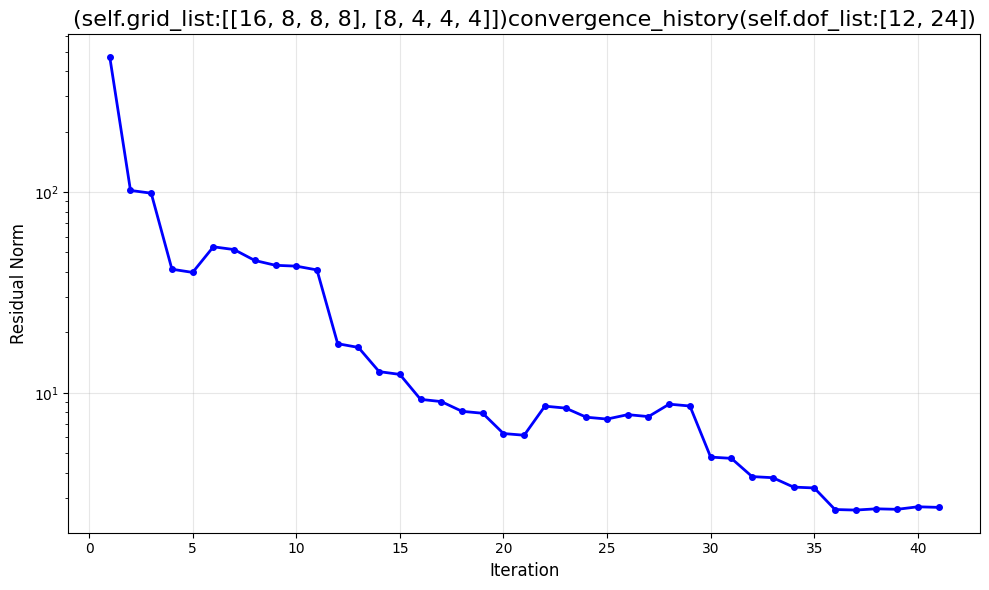

In [21]:
mg.max_iter=20
mg.convergence_history=[]
x = mg.solve()
mg.plot()

In [10]:
mg.lonv_list[0].shape

torch.Size([24, 12, 8, 2, 4, 2, 4, 2, 4, 2])

In [11]:
(mg.b_list[0]-mg.op_list[0].matvec(x.reshape([12]+list(x.shape[-4:])))).flatten()[:100]

tensor([-0.0066-0.0115j, -0.0034-0.0108j, -0.0016-0.0088j, -0.0061-0.0131j,
        -0.0023-0.0103j, -0.0084-0.0115j, -0.0077-0.0144j, -0.0046-0.0105j,
        -0.0049-0.0081j, -0.0034-0.0081j, -0.0056-0.0101j, -0.0041-0.0098j,
        -0.0030-0.0101j, -0.0044-0.0088j, -0.0085-0.0116j, -0.0061-0.0127j,
        -0.0016-0.0115j, -0.0011-0.0109j, -0.0026-0.0096j, -0.0053-0.0100j,
        -0.0050-0.0132j, -0.0084-0.0104j, -0.0052-0.0113j, -0.0088-0.0103j,
        -0.0066-0.0137j, -0.0041-0.0106j, -0.0045-0.0107j, -0.0065-0.0112j,
        -0.0077-0.0090j, -0.0057-0.0116j, -0.0075-0.0099j, -0.0052-0.0116j,
        -0.0041-0.0090j, -0.0056-0.0112j, -0.0053-0.0105j, -0.0099-0.0118j,
        -0.0052-0.0100j, -0.0063-0.0124j, -0.0068-0.0112j, -0.0071-0.0118j,
        -0.0051-0.0087j, -0.0075-0.0103j, -0.0067-0.0140j, -0.0024-0.0121j,
        -0.0103-0.0148j, -0.0071-0.0086j, -0.0069-0.0128j, -0.0078-0.0102j,
        -0.0067-0.0121j, -0.0036-0.0103j, -0.0058-0.0099j, -0.0071-0.0135j,
        -0.0

In [12]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

0.5140591152999049


In [13]:
mg.num_levels

2

In [14]:
index = 0
null_vecs = mg.nv_list[index]
matvec = mg.op_list[index].matvec
for i in range(null_vecs.shape[0]):
    print(
        f"(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:{(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]}")

(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0080-0.0156j, 0.0095-0.0150j, 0.0123-0.0173j, 0.0152-0.0148j,
        0.0087-0.0137j, 0.0153-0.0132j, 0.0121-0.0129j, 0.0162-0.0196j,
        0.0212-0.0216j, 0.0063-0.0111j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0047-0.0020j, 0.0041-0.0015j, 0.0045-0.0018j, 0.0046-0.0028j,
        0.0039-0.0012j, 0.0028-0.0037j, 0.0043-0.0022j, 0.0030-0.0039j,
        0.0041-0.0037j, 0.0054-0.0017j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0118-0.0041j, 0.0114-0.0032j, 0.0116-0.0040j, 0.0113-0.0024j,
        0.0128-0.0034j, 0.0119-0.0008j, 0.0113-0.0040j, 0.0125-0.0031j,
        0.0124-0.0020j, 0.0111-0.0043j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0021+0.0091j, 0.0039+0.0083j, 0.0025+0.0068j, 0.0034+0.0077j,
        0.0016+0.0098j, 0

In [15]:
mg.nv_list[-1].flatten()[:100]

tensor([-0.0017-6.5716e-04j, -0.0020-6.8684e-04j, -0.0016-4.6155e-04j,
        -0.0020-2.6414e-04j, -0.0019-6.2737e-04j, -0.0023-4.5740e-04j,
        -0.0018-2.4737e-04j, -0.0020-1.7316e-04j, -0.0016-1.3339e-04j,
        -0.0024-1.1040e-03j, -0.0022-7.6454e-04j, -0.0016-5.2917e-04j,
        -0.0020-2.3816e-04j, -0.0016-6.7073e-04j, -0.0017-6.9098e-05j,
        -0.0017-1.6942e-04j, -0.0021-8.7061e-04j, -0.0023-1.3356e-03j,
        -0.0019-6.8280e-04j, -0.0021-8.6072e-04j, -0.0016+9.9812e-05j,
        -0.0023-3.9041e-04j, -0.0016-2.9537e-04j, -0.0015-2.0405e-04j,
        -0.0020-8.1315e-04j, -0.0014-9.5827e-04j, -0.0019-7.6720e-04j,
        -0.0015-2.2563e-04j, -0.0013+2.3586e-04j, -0.0014-7.3506e-04j,
        -0.0020-5.8965e-04j, -0.0017-5.3707e-04j, -0.0010-7.0747e-04j,
        -0.0015-2.5641e-04j, -0.0024-9.7411e-04j, -0.0020-7.0257e-04j,
        -0.0022+6.8796e-05j, -0.0021-1.0571e-03j, -0.0020-8.4646e-04j,
        -0.0016-3.9840e-04j, -0.0012-6.6153e-04j, -0.0018-4.0100e-04j,
      

In [16]:
_null_vec = torch.randn_like(null_vecs[0])*10000
print(torch.norm(matvec(_null_vec)))
print(matvec(_null_vec).flatten()[:20])
_null_vec -= inverse.bicgstab(b=matvec(_null_vec), matvec=matvec, tol=5e-5)
print(torch.norm(_null_vec))
print(_null_vec.flatten()[:20])
_null_vec/=torch.norm(_null_vec).item()
print(
    f"(matvec(_null_vec)/_null_vec).flatten()[:10]:{(matvec(_null_vec)/_null_vec).flatten()[:10]}")

tensor(3523297.9715, device='cuda:0', dtype=torch.float64)


tensor([  3545.2267+11708.7719j,   6304.6819+4961.3750j,
          6613.8215+3789.9682j,  -6319.5593+14553.5421j,
         -6781.9067-1678.6474j,  -3622.1475-2510.1221j,
         -2260.6556-2367.9173j,   -576.1349+12273.6525j,
         -5364.2436-2576.5321j,   8157.4400-2011.1747j,
          -275.3290-17644.2571j,   1366.8007-14011.4931j,
          8425.8714+4459.0570j,  -2975.7381+7067.0547j,
         -2065.3680-3778.2606j,  -8838.8615-1354.3317j,
         14813.0357+5112.6500j, -21744.5980-2183.5888j,
         -3482.8324-5214.4378j,  16905.8425+4022.2833j], device='cuda:0',
       dtype=torch.complex128)
Norm of b:3523297.9714643694
Norm of r:3523299.2696537287
Norm of x0:313.1207114280581
BICGSTAB-Iteration 0: Residual = 6.061471e+05, Time = 0.006800 s
BICGSTAB-Iteration 1: Residual = 1.992777e+05, Time = 0.006730 s
BICGSTAB-Iteration 2: Residual = 3.677816e+05, Time = 0.007615 s
BICGSTAB-Iteration 3: Residual = 6.741615e+04, Time = 0.006574 s
BICGSTAB-Iteration 4: Residual = 4.5165

In [17]:
_b = torch.randn_like(null_vecs[0])
_x = inverse.bicgstab(b=_b, matvec=matvec, tol=1e-8)
print((_b-matvec(_x)).flatten()[:100])
print(torch.norm(_b))
print(torch.norm(_x))

Norm of b:314.1870495508896
Norm of r:472.42542009022793
Norm of x0:313.8273273720025
BICGSTAB-Iteration 0: Residual = 1.022600e+02, Time = 0.006777 s
BICGSTAB-Iteration 1: Residual = 4.831102e+01, Time = 0.006656 s
BICGSTAB-Iteration 2: Residual = 4.365526e+01, Time = 0.006601 s
BICGSTAB-Iteration 3: Residual = 3.079389e+01, Time = 0.006944 s
BICGSTAB-Iteration 4: Residual = 1.930005e+01, Time = 0.006735 s
BICGSTAB-Iteration 5: Residual = 1.477457e+01, Time = 0.006764 s
BICGSTAB-Iteration 6: Residual = 1.871729e+01, Time = 0.006700 s
BICGSTAB-Iteration 7: Residual = 2.978978e+01, Time = 0.006444 s
BICGSTAB-Iteration 8: Residual = 9.064561e+00, Time = 0.006701 s
BICGSTAB-Iteration 9: Residual = 7.576875e+00, Time = 0.006285 s
BICGSTAB-Iteration 10: Residual = 6.087249e+00, Time = 0.006613 s
BICGSTAB-Iteration 11: Residual = 5.878854e+00, Time = 0.006277 s
BICGSTAB-Iteration 12: Residual = 5.137120e+00, Time = 0.006729 s
BICGSTAB-Iteration 13: Residual = 4.600423e+00, Time = 0.007270 s


In [18]:
_null_vec.flatten()[:100]

tensor([0.0041-6.3671e-04j, 0.0042-5.5457e-04j, 0.0043-6.3361e-04j,
        0.0048-7.8341e-04j, 0.0046-8.3996e-04j, 0.0049-9.3522e-04j,
        0.0051-1.1819e-03j, 0.0048-1.3451e-03j, 0.0039-9.0895e-04j,
        0.0047-1.7997e-04j, 0.0048-4.6257e-04j, 0.0040-5.1560e-04j,
        0.0047-1.0857e-04j, 0.0043-5.3963e-05j, 0.0047-1.4720e-03j,
        0.0046-1.4560e-03j, 0.0044-4.6984e-04j, 0.0045-2.7591e-04j,
        0.0045-3.4221e-04j, 0.0049-3.7377e-04j, 0.0046-8.1535e-04j,
        0.0048-6.5256e-04j, 0.0043-9.0816e-04j, 0.0038-1.3094e-03j,
        0.0044-9.2977e-04j, 0.0040-4.0809e-04j, 0.0043-5.2172e-04j,
        0.0039-8.7636e-04j, 0.0044-1.3903e-03j, 0.0043-8.1871e-04j,
        0.0044-8.0756e-04j, 0.0042-1.2094e-03j, 0.0045-5.5456e-04j,
        0.0044-1.0078e-03j, 0.0047-1.1225e-03j, 0.0044-6.1994e-04j,
        0.0049-1.2545e-03j, 0.0046-3.6896e-04j, 0.0043-5.3384e-04j,
        0.0045-8.5281e-04j, 0.0043-7.6148e-04j, 0.0046-1.1452e-03j,
        0.0051-1.0360e-03j, 0.0051-7.6520e-04j, 